In [1]:
import os
import numpy as np
import pandas as pd
import rasterio as rio
import geopandas as gpd
from rasterio.plot import show
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

-------------------------

# __Texas HPA__

## Is ET more correlated to precipitation or Irrigation?

### ET vs Precip : Irrigated

In [16]:
TX_monthly_df = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/2km/TX_monthly.csv')
# TX_monthly_df.head()

In [17]:
TX_irrigated_df = TX_monthly_df[TX_monthly_df['Irrigated'] == 1]
# TX_irrigated_df.head()

In [18]:
x = TX_irrigated_df[['PRISM_PPT']]
y = TX_irrigated_df[['Irrigated_cropET']]

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

# linear model
lm = LinearRegression()
lm_trained = lm.fit(x_train, y_train)
lm_trained.coef_

array([[0.22800785]])

Coefficient of determination: 0.06


Text(0, 0.5, 'Monthly Irrigated cropET (mm)')

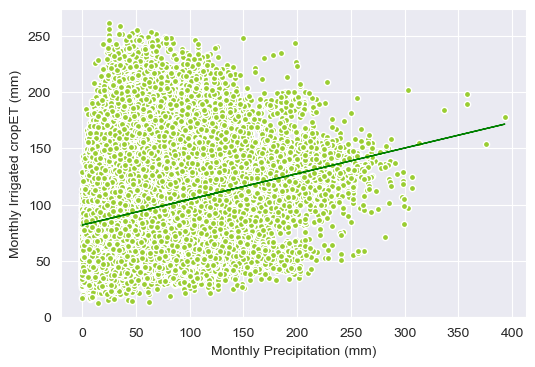

In [19]:
# R2 
y_test_pred = lm_trained.predict(x_test)
r2 = r2_score(y_test, y_test_pred)

# plot performance
fig, ax = plt.subplots(figsize=(6, 4))
sns.set_style("darkgrid")

print("Coefficient of determination: %.2f" % r2)
plt.scatter(x_test, y_test, facecolor='yellowgreen', edgecolor='white', s=20)
plt.plot(x_test, y_test_pred, color='green', linewidth=1)
plt.xlabel('Monthly Precipitation (mm)')
plt.ylabel('Monthly Irrigated cropET (mm)')

### ET vs Precip : Rainfed

In [20]:
TX_rainfed_df = TX_monthly_df[TX_monthly_df['Rainfed'] == 1]
# TX_rainfed_df.head()

In [21]:
x = TX_rainfed_df[['PRISM_PPT']]
y = TX_rainfed_df[['Rainfed_cropET']]

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

# linear model
lm = LinearRegression()
lm_trained = lm.fit(x_train, y_train)
lm_trained.coef_

array([[0.19738478]])

Coefficient of determination: 0.11


Text(0, 0.5, 'Monthly Rainfed cropET (mm)')

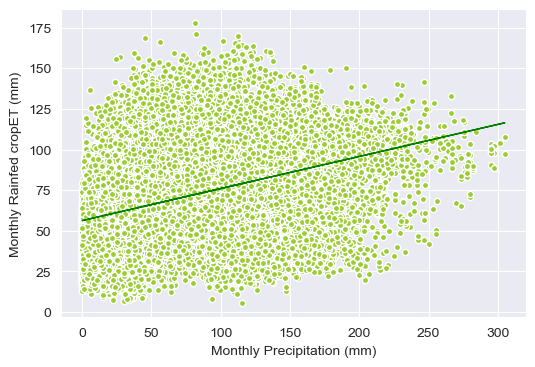

In [22]:
# R2 
y_test_pred = lm_trained.predict(x_test)
r2 = r2_score(y_test, y_test_pred)

# plot performance
fig, ax = plt.subplots(figsize=(6, 4))
sns.set_style("darkgrid")

print("Coefficient of determination: %.2f" % r2)
plt.scatter(x_test, y_test, facecolor='yellowgreen', edgecolor='white', s=20)
plt.plot(x_test, y_test_pred, color='green', linewidth=1)
plt.xlabel('Monthly Precipitation (mm)')
plt.ylabel('Monthly Rainfed cropET (mm)')

# How ET varies with crop type

In [5]:
# USDA CDL crop classification
USDA_cdl_class_df = pd.read_csv('../../Data_main\Data_Drivers_of_ET/CSVs/USDA_cdl_classification.csv')
USDA_cdl_class_df = USDA_cdl_class_df.set_index(keys='Class')
# USDA_cdl_class_df.head()

# making the df to a dictionary
usda_cdl_dict = USDA_cdl_class_df.to_dict()
usda_cdl_dict = usda_cdl_dict['Crop']
# usda_cdl_dict

## Irrigated vs rainfed monthly

In [7]:
TX_monthly_df = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/2km/TX_monthly.csv')

# irrigated and rainfed crop status and irrigated and rainfed cropET are exclusive. Creating columns to bring them in same colums for plotting purpose
TX_monthly_df['Irrig_stat'] = ['Irrigated'  if i == 1 else 'Rainfed' for i in TX_monthly_df.Irrigated] 
TX_monthly_df['Irrig_rainfed_cropET'] = TX_monthly_df['Irrigated_cropET'] + TX_monthly_df['Rainfed_cropET']

# filtering out some cells which are neither irrigated or rainfed (0 values were assigned from reference raster)
TX_monthly_df = TX_monthly_df[(TX_monthly_df.Irrigated == 1) | (TX_monthly_df.Rainfed == 1)]

# mapping name of crop type using USDA CDL dictionary
TX_monthly_df.loc[:, 'Crop'] = TX_monthly_df['USDA_CDL'].map(usda_cdl_dict)
TX_monthly_df.head()

,OpenET,year,month,Irrigated_cropET,Rainfed_cropET,PRISM_PPT,USDA_CDL,Irrigated,Rainfed,Irrig_stat,Irrig_rainfed_cropET,Crop
0,41.0,2016,4,0.000000,40.105934,107.379,176.0,0.0,1.0,Rainfed,40.105934,Grassland/Pasture
1,39.0,2016,4,0.000000,39.466534,104.834,176.0,0.0,1.0,Rainfed,39.466534,Grassland/Pasture
4,55.0,2016,4,55.272636,0.000000,103.366,176.0,1.0,0.0,Irrigated,55.272636,Grassland/Pasture
5,65.0,2016,4,74.220540,0.000000,103.366,176.0,1.0,0.0,Irrigated,74.220540,Grassland/Pasture
6,54.0,2016,4,54.922180,0.000000,106.270,176.0,1.0,0.0,Irrigated,54.922180,Grassland/Pasture


In [10]:
# Filtering Irrigated data only for TX
TX_irrigated_df = TX_monthly_df[TX_monthly_df['Irrigated'] == 1]
print(f'{len(TX_irrigated_df.Crop.unique())} Unique irrigated crop types in TX', TX_irrigated_df.Crop.unique())
TX_irrigated_df_filtered = TX_irrigated_df[TX_irrigated_df['Crop'].isin(['Corn', 'Winter Wheat', 'Cotton', 'Sorghum'])]
TX_irrigated_df_filtered = TX_irrigated_df_filtered[TX_irrigated_df['month'].isin([4, 5, 6, 7, 8, 9, 10])]

# Filtering Rainfed data only for TX
TX_rainfed_df = TX_monthly_df[TX_monthly_df['Rainfed'] == 1]
print(f'{len(TX_rainfed_df.Crop.unique())}Unique rainfed crop types in TX', TX_rainfed_df.Crop.unique())
TX_rainfed_df_filtered = TX_rainfed_df[TX_rainfed_df['Crop'].isin(['Corn', 'Winter Wheat', 'Cotton', 'Sorghum'])]
TX_rainfed_df_filtered = TX_rainfed_df_filtered[TX_rainfed_df_filtered['month'].isin([4, 5, 6, 7, 8, 9, 10])]

27 Unique irrigated crop types in TX ['Grassland/Pasture' 'Corn' 'Winter Wheat' 'Cotton' 'Sorghum' 'Alfalfa'
 'Dbl Crop WinWht/Corn' 'Triticale' 'Dbl Crop WinWht/Sorghum' 'Sweet Corn'
 'Potatoes' 'Soybeans' 'Barley' 'Oats' 'Sod/Grass Seed'
 'Other Hay/Non Alfalfa' 'Millet' 'Peanuts' 'Dbl Crop WinWht/Cotton'
 'Sunflower' 'Pecans' 'Dry Beans' 'Rye' 'Other Crops'
 'Dbl Crop WinWht/Soybeans' 'Pumpkins' 'Dbl Crop Triticale/Corn']
19Unique rainfed crop types in TX ['Grassland/Pasture' 'Winter Wheat' 'Sorghum' 'Corn' 'Cotton' 'Sunflower'
 'Triticale' 'Other Hay/Non Alfalfa' 'Sod/Grass Seed' 'Peanuts' 'Oats'
 'Dbl Crop WinWht/Cotton' 'Millet' 'Soybeans' 'Dbl Crop WinWht/Sorghum'
 'Barley' 'Other Crops' 'Alfalfa' 'Herbs']


C:\Users\fahim\AppData\Local\Temp\ipykernel_27812\1163050322.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TX_irrigated_df_filtered = TX_irrigated_df_filtered[TX_irrigated_df['month'].isin([4, 5, 6, 7, 8, 9, 10])]


(0.0, 300.0)

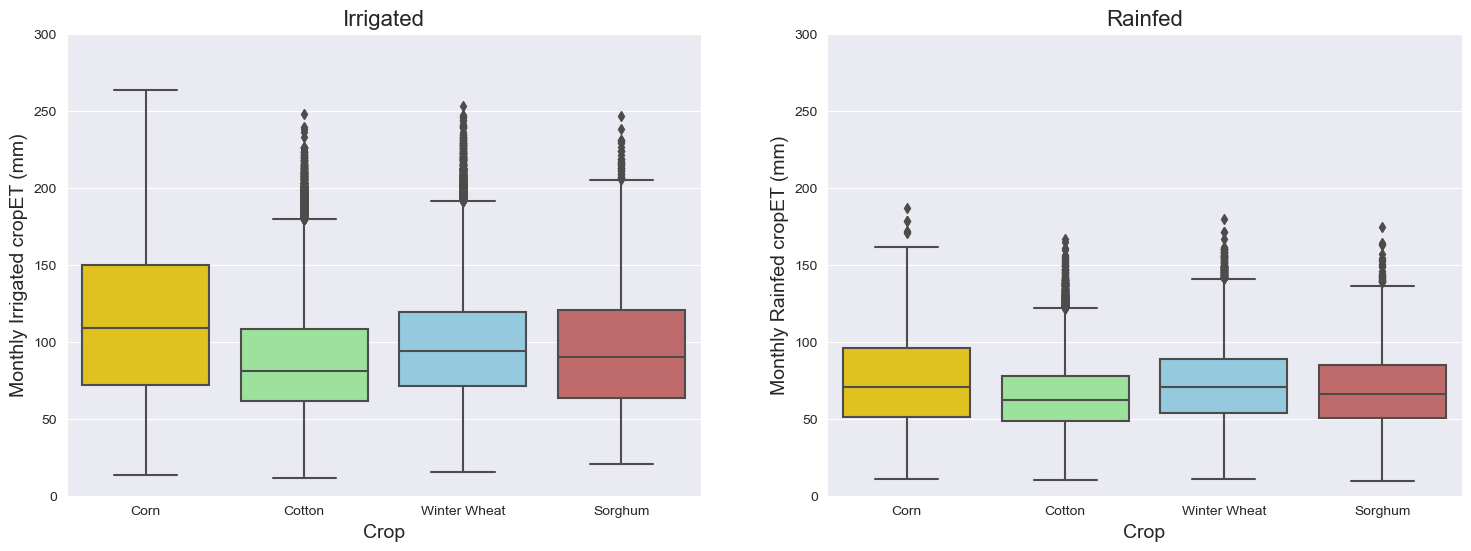

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("darkgrid")

# setting similar color palette for similar crops 
category_colors = {'Corn': 'gold', 'Cotton': 'lightgreen', 'Winter Wheat': 'skyblue', 'Sorghum': 'indianred', 'Alfalfa': 'lightgreen', 
                          'Soybeans': 'tan', 'Grassland/Pasture': 'palegoldenrod'}

# category order
category_order_irr = ['Corn', 'Cotton', 'Winter Wheat', 'Sorghum']
category_order_rain = ['Corn', 'Cotton', 'Winter Wheat', 'Sorghum']

# irrigated
sns.boxplot(x=TX_irrigated_df_filtered['Crop'], y=TX_irrigated_df_filtered['Irrigated_cropET'], ax=ax[0], palette=category_colors, order=category_order_irr)
ax[0].set_xlabel('Crop', fontsize=14)
ax[0].set_ylabel('Monthly Irrigated cropET (mm)', fontsize=14)
ax[0].tick_params(axis='both', labelsize=10)
ax[0].set_title('Irrigated', fontsize=16)
ax[0].set_ylim(0, 300)

# rainfed
sns.boxplot(x=TX_rainfed_df_filtered['Crop'], y=TX_rainfed_df_filtered['Rainfed_cropET'], ax=ax[1], palette=category_colors, order=category_order_rain)
ax[1].set_xlabel('Crop', fontsize=14)
ax[1].set_ylabel('Monthly Rainfed cropET (mm)', fontsize=14)
ax[1].tick_params(axis='both', labelsize=10)
ax[1].set_title('Rainfed', fontsize=16)
ax[1].set_ylim(0, 300)

Except Soybeans, all other crops seems to have higher median irrigated cropET than rainfed cropET

#### Corn

(0.0, 300.0)

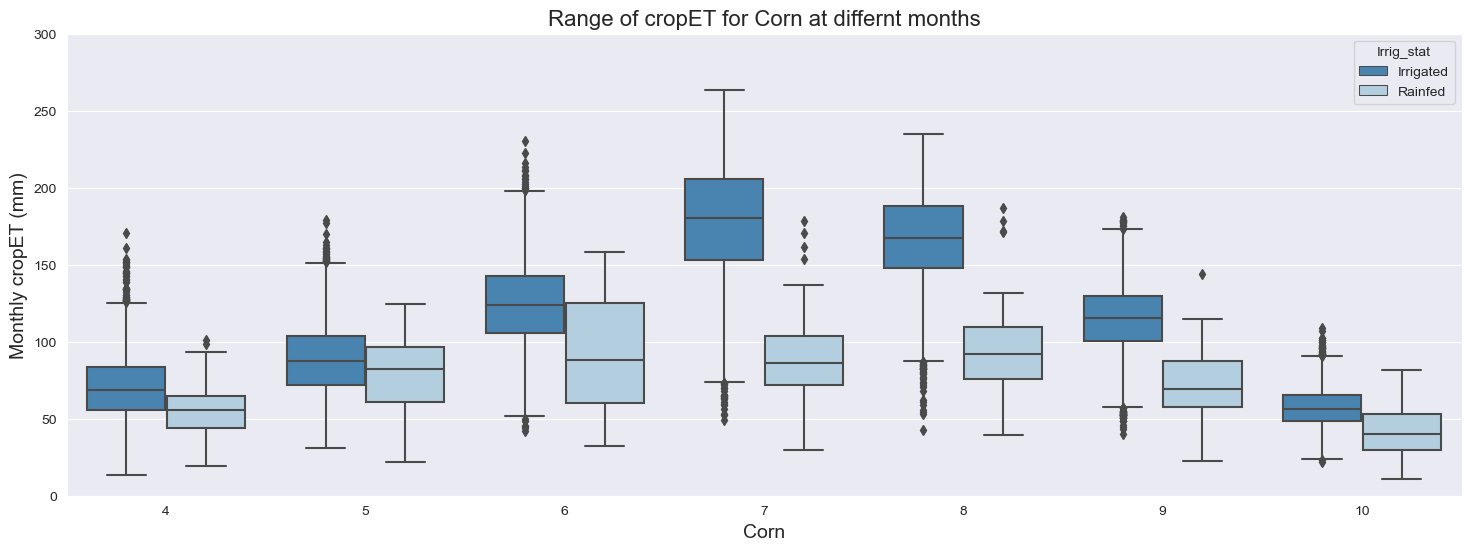

In [13]:
TX_df_crop = TX_monthly_df[TX_monthly_df['Crop'] == 'Corn']

fig, ax = plt.subplots(figsize=(18, 6))
sns.set_style("darkgrid")

sns.boxplot(x=TX_df_crop['month'], y=TX_df_crop['Irrig_rainfed_cropET'], ax=ax, hue=TX_df_crop['Irrig_stat'], palette='Blues_r')
ax.set_xlabel('Corn', fontsize=14)
ax.set_ylabel('Monthly cropET (mm)', fontsize=14)
ax.tick_params(axis='both', labelsize=10)
ax.set_title('Range of cropET for Corn at differnt months', fontsize=16)
ax.set_ylim(0, 300)

For corn, median __irrigated cropET > rainfed cropET__ for `4-10`.

#### WInter Wheat

(0.0, 300.0)

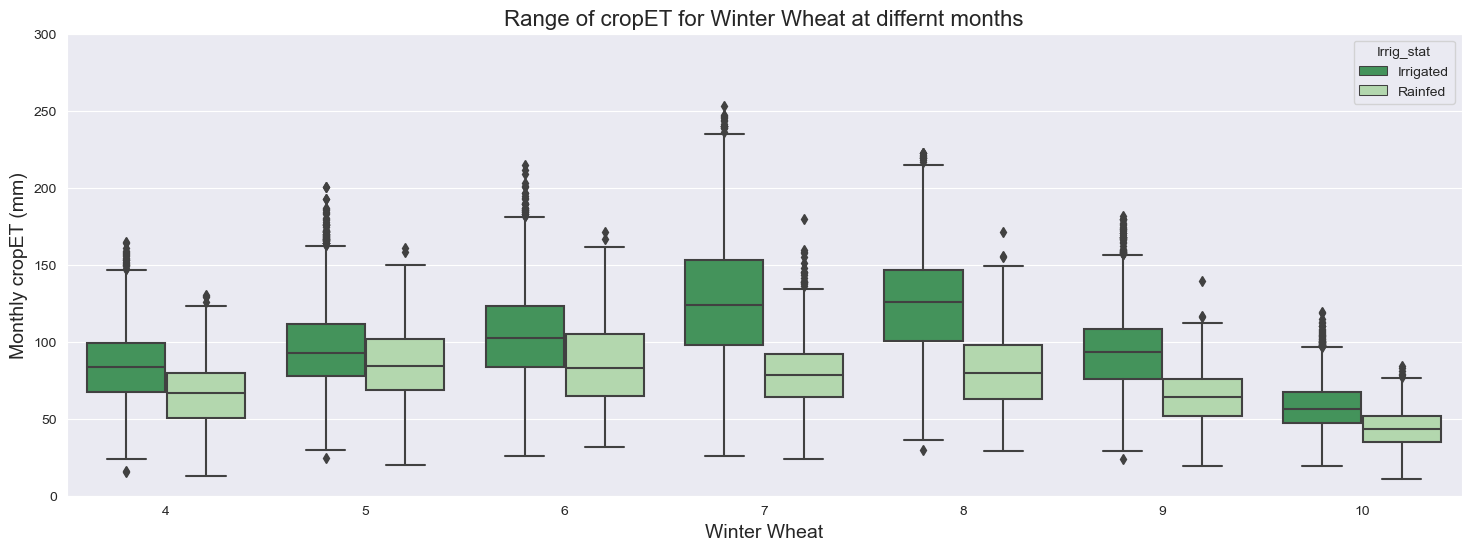

In [14]:
TX_df_crop = TX_monthly_df[TX_monthly_df['Crop'] == 'Winter Wheat']

fig, ax = plt.subplots(figsize=(18, 6))
sns.set_style("darkgrid")

sns.boxplot(x=TX_df_crop['month'], y=TX_df_crop['Irrig_rainfed_cropET'], ax=ax, hue=TX_df_crop['Irrig_stat'], palette='Greens_r')
ax.set_xlabel('Winter Wheat', fontsize=14)
ax.set_ylabel('Monthly cropET (mm)', fontsize=14)
ax.tick_params(axis='both', labelsize=10)
ax.set_title('Range of cropET for Winter Wheat at differnt months', fontsize=16)
ax.set_ylim(0, 300)

For Winter Wheat, median __irrigated cropET > rainfed cropET__ for `4-10`.

#### Cotton

(0.0, 300.0)

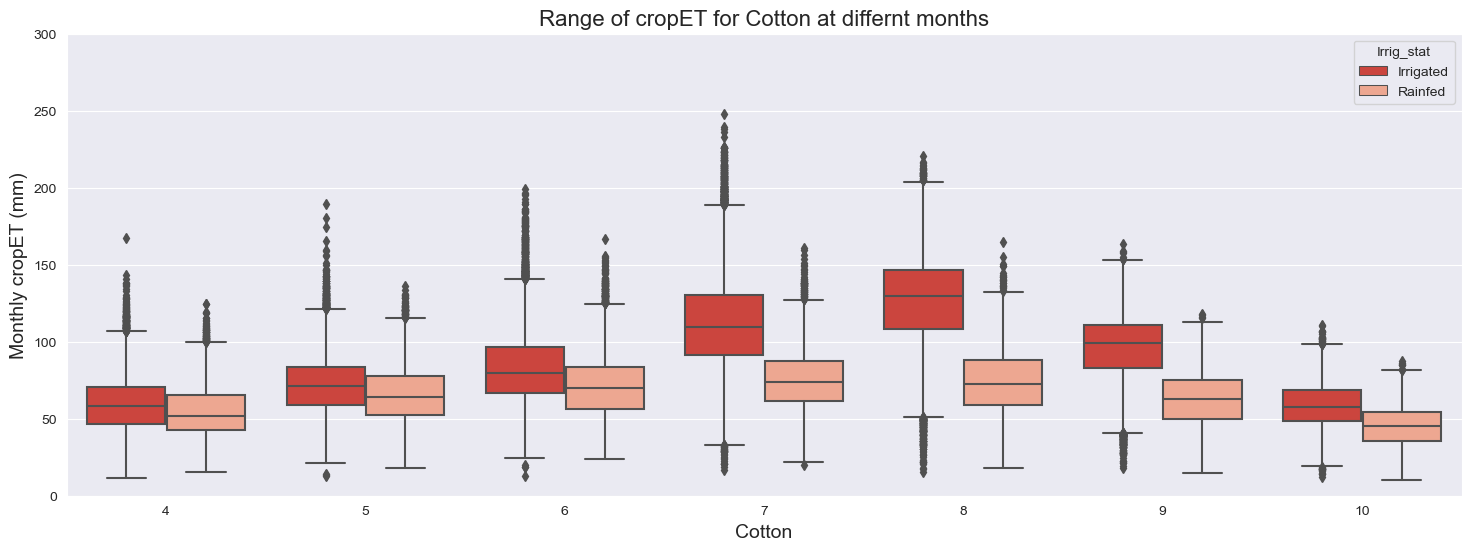

In [15]:
TX_df_crop = TX_monthly_df[TX_monthly_df['Crop'] == 'Cotton']

fig, ax = plt.subplots(figsize=(18, 6))
sns.set_style("darkgrid")

sns.boxplot(x=TX_df_crop['month'], y=TX_df_crop['Irrig_rainfed_cropET'], ax=ax, hue=TX_df_crop['Irrig_stat'], palette='Reds_r')
ax.set_xlabel('Cotton', fontsize=14)
ax.set_ylabel('Monthly cropET (mm)', fontsize=14)
ax.tick_params(axis='both', labelsize=10)
ax.set_title('Range of cropET for Cotton at differnt months', fontsize=16)
ax.set_ylim(0, 300)

For Cotton, median __irrigated cropET > rainfed cropET__ for `4-10`.

## Irrigated vs rainfed yearly

In [6]:
TX_yearly_df = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/2km/TX_yearly.csv')

# irrigated and rainfed crop status and irrigated and rainfed cropET are exclusive. Creating columns to bring them in same colums for plotting purpose
TX_yearly_df['Irrig_stat'] = ['Irrigated'  if i == 1 else 'Rainfed' for i in TX_yearly_df.Irrigated] 
TX_yearly_df['Irrig_rainfed_cropET'] = TX_yearly_df['Irrigated_cropET'] + TX_yearly_df['Rainfed_cropET']

# filtering out some cells which are neither irrigated or rainfed (0 values were assigned from reference raster)
TX_yearly_df = TX_yearly_df[(TX_yearly_df.Irrigated == 1) | (TX_yearly_df.Rainfed == 1)]

# mapping name of crop type using USDA CDL dictionary
TX_yearly_df.loc[:, 'Crop'] = TX_yearly_df['USDA_CDL'].map(usda_cdl_dict)
TX_yearly_df.head()

,USDA_CDL,Irrigated,Rainfed,Irrigated_cropET,Rainfed_cropET,Irrig_stat,Irrig_rainfed_cropET,Crop
0,176.0,0.0,1.0,0.00000,467.6636,Rainfed,467.66360,Grassland/Pasture
1,176.0,0.0,1.0,0.00000,454.5269,Rainfed,454.52690,Grassland/Pasture
4,176.0,1.0,0.0,677.63120,0.0000,Irrigated,677.63120,Grassland/Pasture
5,176.0,1.0,0.0,741.41590,0.0000,Irrigated,741.41590,Grassland/Pasture
6,176.0,1.0,0.0,626.04535,0.0000,Irrigated,626.04535,Grassland/Pasture


(0.0, 1200.0)

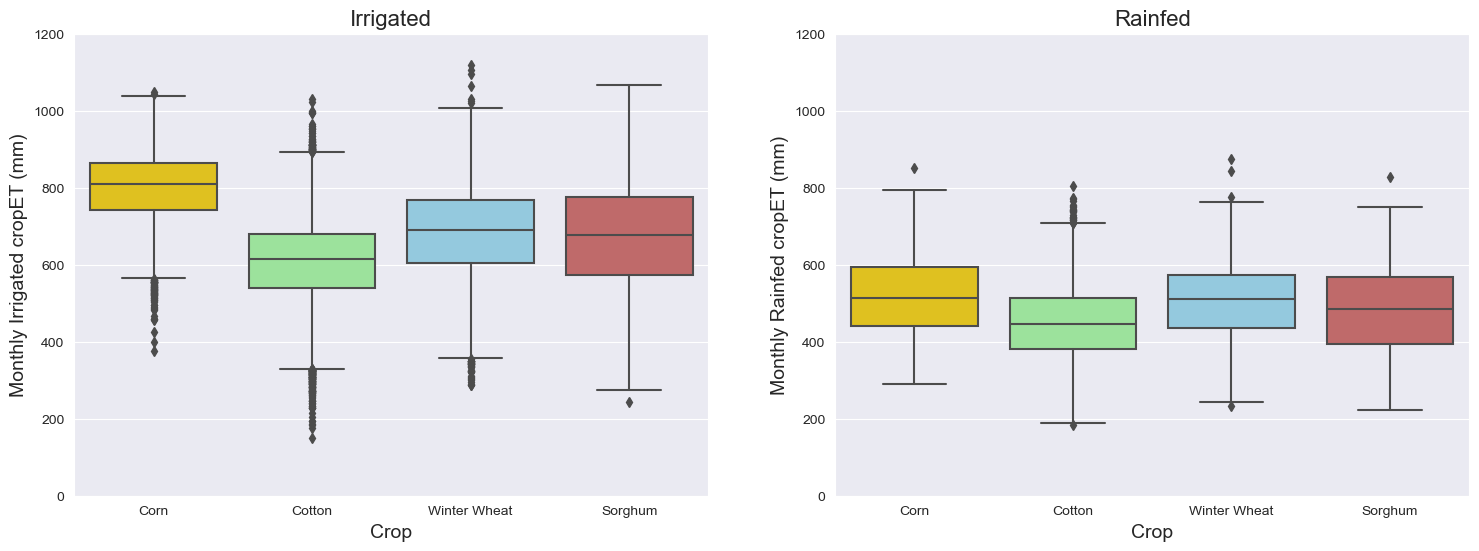

In [8]:
# Filtering Irrigated data only for TX
TX_irrigated_df = TX_yearly_df[TX_yearly_df['Irrigated'] == 1]
TX_irrigated_df_filtered = TX_irrigated_df[TX_irrigated_df['Crop'].isin(['Corn', 'Cotton', 'Winter Wheat', 'Sorghum'])]

# Filtering Rainfed data only for KS
TX_rainfed_df = TX_yearly_df[TX_yearly_df['Rainfed'] == 1]
TX_rainfed_df_filtered = TX_rainfed_df[TX_rainfed_df['Crop'].isin(['Corn', 'Cotton', 'Winter Wheat', 'Sorghum'])]

# Plotting major irrigated and rainfed crops' yearly irrigated and rainfed cropET
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("darkgrid")

# setting similar color palette for similar crops 
category_colors = {'Corn': 'gold', 'Cotton': 'lightgreen', 'Winter Wheat': 'skyblue', 'Sorghum': 'indianred', 
                   'Alfalfa': 'lightgreen', 'Soybeans': 'tan', 'Grassland/Pasture': 'palegoldenrod'}

# category order
category_order_irr = ['Corn', 'Cotton', 'Winter Wheat', 'Sorghum']
category_order_rain = ['Corn', 'Cotton', 'Winter Wheat', 'Sorghum']

# irrigated
sns.boxplot(x=TX_irrigated_df_filtered['Crop'], y=TX_irrigated_df_filtered['Irrigated_cropET'], ax=ax[0], palette=category_colors, order=category_order_irr)
ax[0].set_xlabel('Crop', fontsize=14)
ax[0].set_ylabel('Monthly Irrigated cropET (mm)', fontsize=14)
ax[0].tick_params(axis='both', labelsize=10)
ax[0].set_title('Irrigated', fontsize=16)
ax[0].set_ylim(0, 1200)

# rainfed
sns.boxplot(x=TX_rainfed_df_filtered['Crop'], y=TX_rainfed_df_filtered['Rainfed_cropET'], ax=ax[1], palette=category_colors, order=category_order_rain)
ax[1].set_xlabel('Crop', fontsize=14)
ax[1].set_ylabel('Monthly Rainfed cropET (mm)', fontsize=14)
ax[1].tick_params(axis='both', labelsize=10)
ax[1].set_title('Rainfed', fontsize=16)
ax[1].set_ylim(0, 1200)

### Ratio between Rainfed cropET (Effective Precip) vs Irrigated cropET __Using yearly medians__

In [9]:
TX_irrigated_df = TX_yearly_df[TX_yearly_df['Irrigated'] == 1]
irrigated_cropET_df_count = TX_irrigated_df.groupby(by='Crop', axis=0)['Irrigated_cropET'].count().reset_index()
irrigated_cropET_df_count = irrigated_cropET_df_count.rename(columns={'Irrigated_cropET': 'Irr_count'})
irrigated_cropET_df = TX_irrigated_df.groupby(by='Crop', axis=0)['Irrigated_cropET'].median()
irrigated_cropET_df = irrigated_cropET_df.reset_index()


TX_rainfed_df = TX_yearly_df[TX_yearly_df['Rainfed'] == 1]
rainfed_cropET_df_count = TX_rainfed_df.groupby(by='Crop', axis=0)['Rainfed_cropET'].count().reset_index()
rainfed_cropET_df_count = rainfed_cropET_df_count.rename(columns={'Rainfed_cropET': 'Rain_count'})
rainfed_cropET_df = TX_rainfed_df.groupby(by='Crop', axis=0)['Rainfed_cropET'].median()
rainfed_cropET_df = rainfed_cropET_df.reset_index()

# merging 2 dataframes
effective_precip_ratio_df = irrigated_cropET_df.merge(rainfed_cropET_df, on=['Crop']).merge(irrigated_cropET_df_count, on='Crop').merge(rainfed_cropET_df_count, on='Crop')
effective_precip_ratio_df['ratio_effec_precip'] = effective_precip_ratio_df['Rainfed_cropET'] / effective_precip_ratio_df['Irrigated_cropET']
effective_precip_ratio_df

,Crop,Irrigated_cropET,Rainfed_cropET,Irr_count,Rain_count,ratio_effec_precip
0,Alfalfa,863.656370,405.231050,138,1,0.469204
1,Barley,729.709330,515.477280,6,4,0.706415
2,Corn,808.824050,512.267040,3822,70,0.633348
3,Cotton,615.306100,445.449070,16441,7075,0.723947
4,Dbl Crop WinWht/Cotton,674.114215,572.748985,18,8,0.849632
5,Dbl Crop WinWht/Sorghum,848.014750,448.315120,54,5,0.528664
6,Grassland/Pasture,706.144100,480.307500,5739,22505,0.680183
7,Millet,646.264100,410.740295,9,6,0.635561
8,Oats,749.782840,505.707570,5,2,0.674472
9,Other Crops,484.858950,398.456600,2,1,0.821799


We can only trust crops that have relatively significat samples on both side (not disproportionate)
- Barley, Cotton, Dbl Crop WinWht/Cotton, Millet, Grassland/Pasture, Other Hay/Non Alfalfa, Peanuts, Sod/Grass Seed, Sorghum, Sunflower, Winter Wheat	

In [10]:
selected_crops = ['Corn', 'Cotton', 'Grassland/Pasture', 'Other Hay/Non Alfalfa', 
                  'Peanuts', 'Sod/Grass Seed', 'Sorghum', 'Winter Wheat']
effective_precip_ratio_df = effective_precip_ratio_df[effective_precip_ratio_df['Crop'].isin(selected_crops)]
effective_precip_ratio_df = effective_precip_ratio_df.reset_index(drop=True)
effective_precip_ratio_df

,Crop,Irrigated_cropET,Rainfed_cropET,Irr_count,Rain_count,ratio_effec_precip
0,Corn,808.824050,512.26704,3822,70,0.633348
1,Cotton,615.306100,445.44907,16441,7075,0.723947
2,Grassland/Pasture,706.144100,480.30750,5739,22505,0.680183
3,Other Hay/Non Alfalfa,630.110100,534.77130,37,27,0.848695
4,Peanuts,575.964675,394.02725,56,26,0.684117
5,Sod/Grass Seed,714.437135,609.04670,14,13,0.852485
6,Sorghum,677.992500,485.44055,843,465,0.715997
7,Winter Wheat,689.593800,511.84850,7455,2840,0.742246


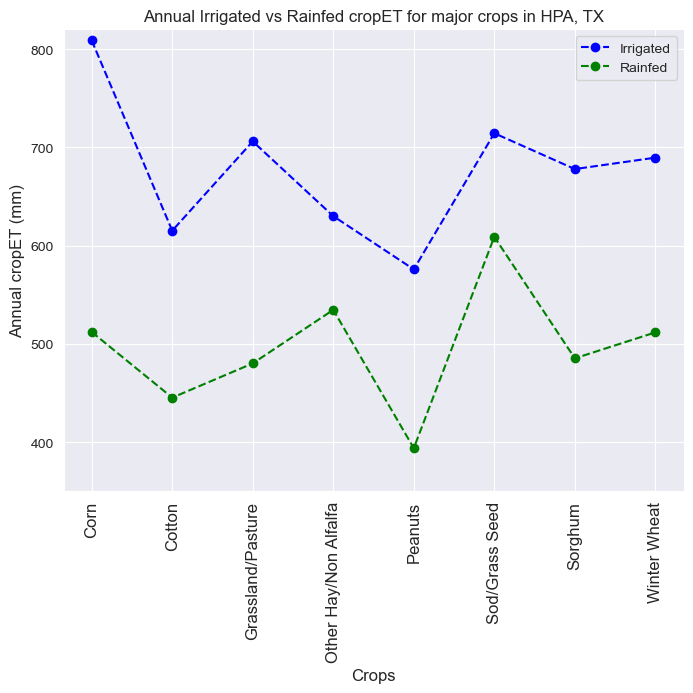

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style("darkgrid")

ax.plot(effective_precip_ratio_df.Irrigated_cropET, 'b--', label='Irrigated', marker='o')
ax.plot(effective_precip_ratio_df.Rainfed_cropET, 'g--', label='Rainfed', marker='o')
ax.set_xticks(list(range(len(effective_precip_ratio_df))), labels= effective_precip_ratio_df.Crop, rotation=90, fontsize=12)
ax.set_xlabel('Crops', fontsize=12)
ax.set_ylabel('Annual cropET (mm)', fontsize=12)
ax.set_ylim(350, 820)
ax.set_title('Annual Irrigated vs Rainfed cropET for major crops in HPA, TX')
ax.legend()